## Load Base Stable Diffusion Model

In [1]:
from diffusers import StableDiffusionImg2ImgPipeline
from pruna.algorithms.smasher_config import AutoSmasherConfig
from pruna.smash import smash
import torch
import requests
from PIL import Image
from io import BytesIO

import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler, StableDiffusionImg2ImgPipeline
import torch
import numpy as np
from diffusers.utils import load_image

image = Image.open(
            BytesIO(
                requests.get(
                    "https://huggingface.co/lllyasviel/sd-controlnet-canny/resolve/main/images/bird_canny.png"
                ).content
            )
        )

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.to('cuda')


Post-training Optimization Tool is deprecated and will be removed in the future. Please use Neural Network Compression Framework instead: https://github.com/openvinotoolkit/nncf
Nevergrad package could not be imported. If you are planning to use any hyperparameter optimization algo, consider installing it using pip. This implies advanced usage of the tool. Note that nevergrad is compatible only with Python 3.7+


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Smash it!

In [2]:
from pruna.algorithms.smasher_config import SmasherConfig

smasher_config = SmasherConfig()
smasher_config['compiler'] = 'diffusers'
smasher_config['max_batch_size'] = 1
smasher_config['image_height'] = 512
smasher_config['image_width'] = 512
smasher_config['version'] = '1.5'
smasher_config['static_shape'] = False
smasher_config['controlnet'] = True

In [3]:
smashed_model = smash(
        model=pipe,
        data_module="img2img",
        api_key='your-api-key',
        model_config=None,
        smasher_config=smasher_config,
        device='cuda',
    )

Received a 500 error, retrying in 3 seconds...
Compile...
[I] Load tokenizer pytorch model from: /nfs/students/rachwan/huggingface/.cache/torch/1.5/IMG2IMG/tokenizer
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/clip.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/unet.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/vae.plan
Success.


In [4]:
prompt = "Yellow Bird"

In [5]:
pipe

StableDiffusionControlNetPipeline {
  "_class_name": "StableDiffusionControlNetPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Base Model Generation

  0%|          | 0/50 [00:00<?, ?it/s]

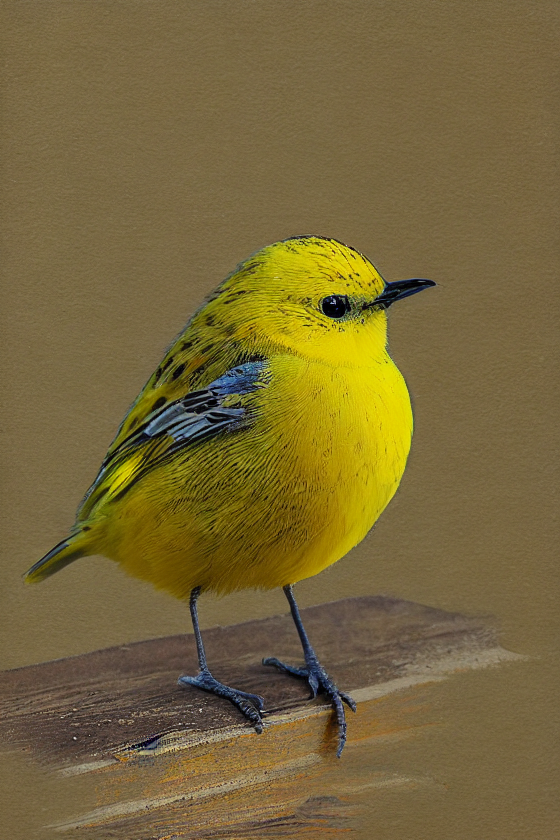

CPU times: user 5 s, sys: 263 ms, total: 5.27 s
Wall time: 6.43 s


In [6]:
%%time
pipe(prompt=prompt, image=image).images[0].show()

## Smashed Model Generation

CPU times: user 2.21 s, sys: 2.2 ms, total: 2.21 s
Wall time: 2.21 s


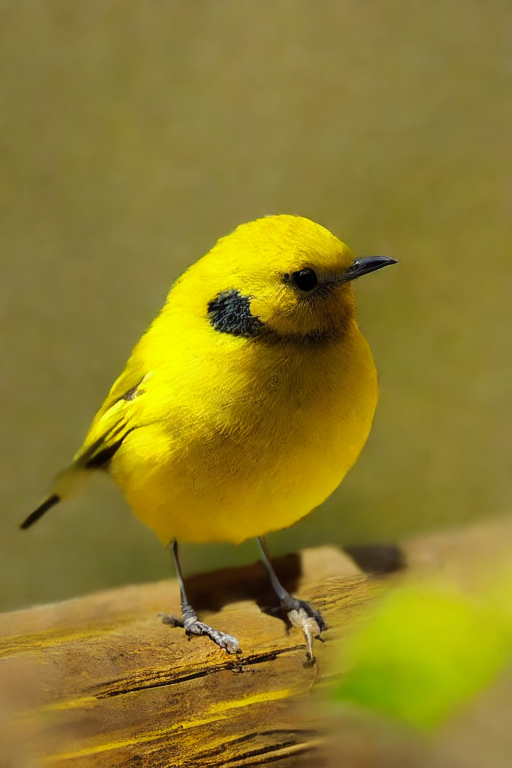

In [8]:
%%time
smashed_model(prompt, init_image=image, image_height=768, image_width=512)[0]